In [1]:
import numpy as np
import os.path as osp
import uproot as ur
from glob import glob

In [2]:
debug = True

if debug:
    filesAIDA = glob('/afs/desy.de/group/flc/pool/bliewert/MarlinWorkdirs/ZHH/scripts/AIDAFile_6f_*.root')
else:
    filesAIDA = glob('/nfs/dust/ilc/user/bliewert/FT_ParticleNet4Tags/MarlinTestingZZH/output/AIDAFile_e2e2qqh.*.root')
    
filesAIDA.sort()

filesFinalStates:list[str] =  []

for file in filesAIDA:
    dn = osp.dirname(file)
    bn = osp.basename(file)
    
    totalsuffix = bn.replace('AIDAFile_', '').replace('.root.root', '')
    p = osp.join(dn, f'FinalStates_{totalsuffix}.root')
    
    filesFinalStates.append(p)
    
print(list(zip(filesAIDA, filesFinalStates)))

[('/afs/desy.de/group/flc/pool/bliewert/MarlinWorkdirs/ZHH/scripts/AIDAFile_6f_ttbar_yycyyc.root.root', '/afs/desy.de/group/flc/pool/bliewert/MarlinWorkdirs/ZHH/scripts/FinalStates_6f_ttbar_yycyyc.root')]


In [3]:
fsf = ur.open(filesFinalStates[0])
aff = ur.open(filesAIDA[0])
#np.sum(aff['JetTaggingComparison']['energy'].array() == aff['Jets']['JetEnergy'].array())

In [4]:
fs_pdgs = fsf['FinalStates']['final_state_counts.first'].array()[0].tolist()
fs_pdgs

[1, 2, 3, 4, 5, 6, 11, 12, 13, 14, 15, 16, 21, 22, 23, 24, 25]

In [5]:
fsc = np.array(fsf['FinalStates']['final_state_counts.second'].array())
fsc

array([[0, 0, 2, ..., 0, 0, 0],
       [0, 0, 2, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 2, ..., 0, 0, 0],
       [0, 0, 2, ..., 0, 0, 0],
       [0, 0, 2, ..., 0, 0, 0]], dtype=int32)

In [6]:
# yycyyc:
# y: down type
# nc + nd + ns + nb = const. = 6
(fsc[:, fs_pdgs.index(4)] + fsc[:, fs_pdgs.index(1)] + fsc[:, fs_pdgs.index(3)] + fsc[:, fs_pdgs.index(5)] != 6).any()

False

In [7]:
fsc[0]

array([0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [8]:
aff['Jets']['TrueJetType'].array()[:6]

<Array [1, 101, 101, 1, 1, 1] type='6 * int32'>

In [9]:
aff['Jets']['TrueJetInitialElementonPDG'].array()[:6]

<Array [-6, 6, 6, 6, 5, -5] type='6 * int32'>

In [10]:
aff['Jets']['TrueJetFinalElementonPDG'].array()[:6]

<Array [-5, 4, -3, 5, 5, -5] type='6 * int32'>

In [11]:
from zhh.analysis.FlavorTagging import parse_files, get_tot_length, plot_roc_two_cases, roc_plot_config, load_ftag_results

/cvmfs/sw.hsf.org/key4hep/releases/2024-10-03/x86_64-almalinux9-gcc14.2.0-opt/py-tqdm/4.66.3-gay4aw/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
y_true, tags, valid_jets_mask = load_ftag_results(filesAIDA, parse_kwargs={ 'exclude_pdgs': None, 'elementon_pdg': 'initial' })

/afs/desy.de/group/flc/pool/bliewert/MarlinWorkdirs/ZHH/scripts/AIDAFile_6f_ttbar_yycyyc.root.root: 100%|██████████| 1/1 [00:00<00:00, 10.78it/s]


In [13]:
plot_defaults = roc_plot_config['options'].clone()
plot_defaults['title_pre'] = r'6f $t\bar{t}$ (yycyyc): '
plot_defaults

[('xmin', 0),
 ('xmax', 1),
 ('ymin', 0),
 ('ymax', 1),
 ('yscale', linear),
 ('title_pre', 6f $t\bar{t}$ (yycyyc): )]

b (ID0, n=18157), c (ID1, n=1174)
b (ID0, n=18157), c (ID1, n=1174)
b (ID0, n=18157), uds (ID2, n=1469)
b (ID0, n=18157), uds (ID2, n=1469)


[<Figure size 600x600 with 1 Axes>,
 <Figure size 600x600 with 1 Axes>,
 <Figure size 600x600 with 1 Axes>,
 <Figure size 600x600 with 1 Axes>]

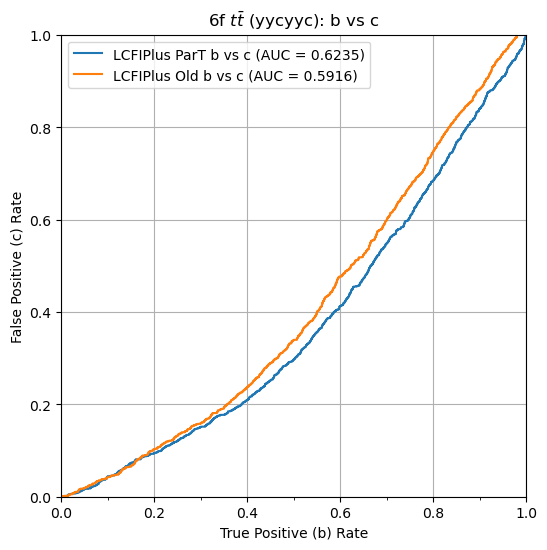

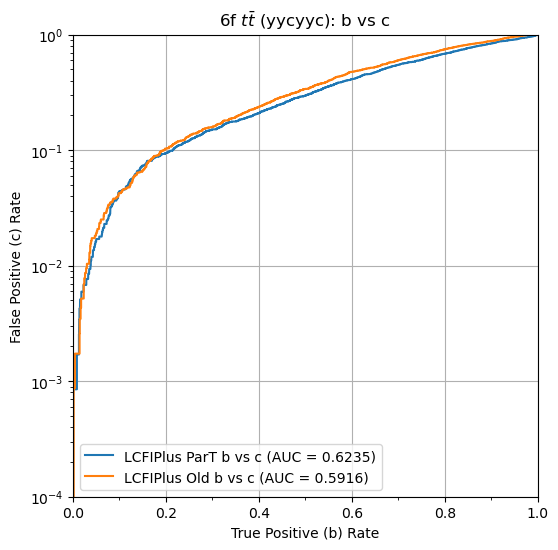

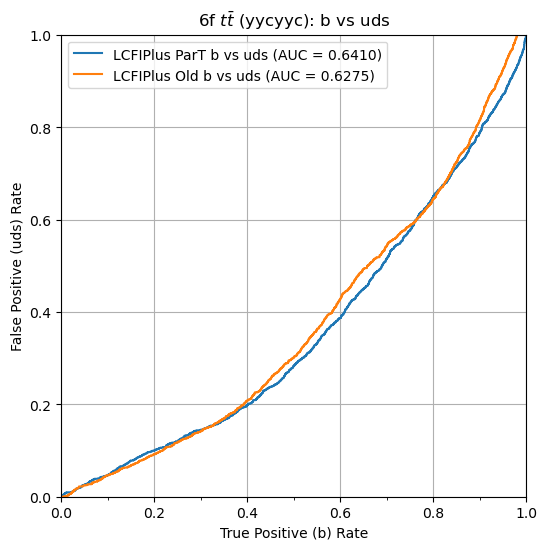

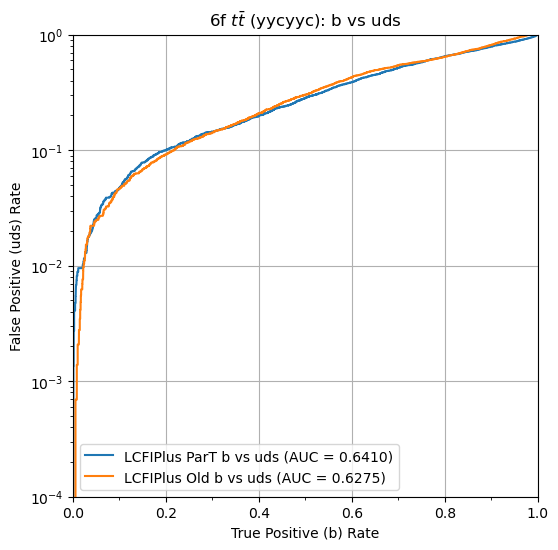

In [14]:
plot_roc_two_cases(y_true, [tags[0], tags[1]], ['LCFIPlus ParT', 'LCFIPlus Old'],
                   to_plot = [('b', 'c'), ('b', 'c'), ('b', 'uds'), ('b', 'uds')],
                   plot_defaults=plot_defaults,
                   plot_options={
                       1: { 'yscale': 'log', 'ymin': 1.E-4 },
                       3: { 'yscale': 'log', 'ymin': 1.E-4 }
})[0]